# Food prices in Turkey - EDA

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Useful Parameter Console
plt.rcParams.update({
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'legend.fontsize': 12
})

In [2]:
train = pd.read_csv('train.csv')
train.head()

,Place,ProductId,ProductName,UmId,UmName,Month,Year,Price
0,National Average,52,Rice - Retail,5,KG,5,2013,4.4920
1,National Average,52,Rice - Retail,5,KG,6,2013,4.5786
2,National Average,52,Rice - Retail,5,KG,11,2013,4.7865
3,National Average,52,Rice - Retail,5,KG,12,2013,5.1337
4,National Average,52,Rice - Retail,5,KG,1,2014,5.5099


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Place        7381 non-null   object 
 1   ProductId    7381 non-null   int64  
 2   ProductName  7381 non-null   object 
 3   UmId         7381 non-null   int64  
 4   UmName       7381 non-null   object 
 5   Month        7381 non-null   int64  
 6   Year         7381 non-null   int64  
 7   Price        7381 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 461.4+ KB


No missing value

In [7]:
train.loc[:, ['ProductId', 'ProductName']].value_counts()

ProductId  ProductName                                           
52         Rice - Retail                                             174
173        Onions - Retail                                           174
463        Milk (pasteurized) - Retail                               174
433        Meat (veal) - Retail                                      174
401        Fish (fresh) - Retail                                     174
281        Tea - Retail                                              174
258        Bulgur - Retail                                           174
254        Bananas - Retail                                          174
58         Wheat flour - Retail                                      174
239        Oil (olive) - Retail                                      174
185        Salt - Retail                                             174
184        Oil (sunflower) - Retail                                  174
183        Meat (mutton) - Retail                         

In [8]:
train.ProductId.nunique() == train.ProductName.nunique()

True

Each `ProducId` correspond to a unique `ProductName`. To verify this another way:

In [12]:
train.groupby('ProductName').ProductId.apply(lambda x: x.nunique()).unique()

array([1])

Indeed, for each product name there is a unique product id.

What is the time-span of the data?

In [13]:
train.Year.unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019])

Let's see how oveerall food prices increased over the years. A sensible regressor should not learn the Year (less the Month) feature, in the sense that the specific year (and month) should not enter the prediction of the prices. The model should incorporate the trend of price-change over the years as an aggregate measure and separately.
For instance, if fitting a linear model to the data, there should possibly be a linear term as in 
$$ y = \displaystyle{\sum}_i x_i + \gamma t $$
<br>
where $t$ is time in some given unit (with some given precision, e.g. year, month, etc.) and $\gamma$ is the linear's term coefficient.

In [16]:
sns.set(font_scale=1.4)

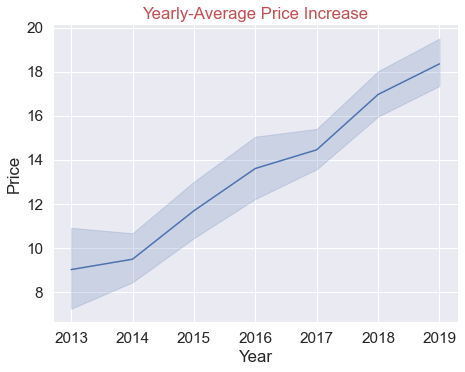

In [19]:
sns.relplot(data=train, x='Year', y='Price', kind='line', ci=95, aspect=1.3)
plt.title('Yearly-Average Price Increase', c='r')
plt.show()

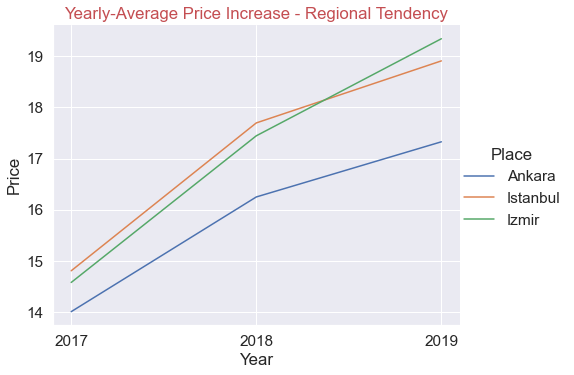

In [39]:
sns.relplot(data=train.query("Place != 'National Average'"), x='Year', y='Price', hue='Place', kind='line',
            ci=None, aspect=1.3)
plt.title('Yearly-Average Price Increase - Regional Tendency', c='r')
plt.xticks([2017, 2018, 2019])
plt.show()

We have no regional data before 2017, so it might be a good idea to incorporate a trend based on the national average since we have a longer timespan of data.

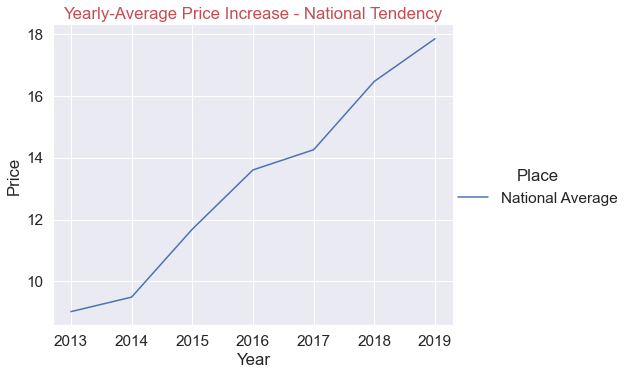

In [41]:
sns.relplot(data=train.query("Place == 'National Average'"), x='Year', y='Price', hue='Place', kind='line',
            ci=None, aspect=1.3)
plt.title('Yearly-Average Price Increase - National Tendency', c='r')

plt.show()

At this point, it might be useful to create a feature that holds average prices by year of each product category.

The idea is to plot a scatter of the national average for each product category and fit a line to it. Then the price would be predicted according to the category and the year. For years beyond the range 2015-2019 the model would interpolate.